# Relevant Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress, ttest_1samp
from sklearn.metrics import r2_score
from sklearn import linear_model

from main_functions import *

# turn off divide-by-zero warnings since these null/NAN values get filtered out
import warnings
warnings.filterwarnings("ignore")

# load experimental data
data = pd.read_excel('data/data.xlsx', sheet_name = '1st Trial', names = ['time (min)', 'm_xylene', 'NO', 'NO2', 'NOx', 'NOx/m_xy', 'beta', 'NO,NO2 crossing time (min)', 'Wall loss factor', 'Peak O3 Concentration', '50% of Final M0 Time', 'PeakDp', 'deltaHC', 'm_xy consume ratio', 'deltaHC / beta', 'deltaHC * beta', 'M0', 'yield'])


# Summary Statistics

In [23]:
summary = np.round(data.describe(), 3)
with pd.ExcelWriter('written_data/summary.xlsx') as file:
    summary.to_excel(file, sheet_name = 'Statistics')

# Computing Correlations

### No transformations

In [24]:
# Determine end of input columns and end of intermediate columns
inp, inter = grab_column_split()

# Grab and color correlations
correlations = data.corr()
inter_correlations = np.round(correlations[data.columns[inp:inter]][:inp], 3)
output_correlations = np.round(correlations[data.columns[inter:]][:-len(data.columns[inter:])], 3)

inter_correlations = corr_highlight(inter_correlations)
output_correlations = corr_highlight(output_correlations)

In [25]:
# Hypothesis Testing for each computed correlation
pvals = data.corr(method = lambda x,y: 1 if (pearsonr(x, y)[1] < 0.05) else 0)
inter_pvals = pvals[data.columns[inp:inter]][:inp]
output_pvals = pvals[data.columns[inter:]][:-len(data.columns[inter:])]

# Highlight if significant
inter_pvals = pval_highlight(inter_pvals)
output_pvals = pval_highlight(output_pvals)

In [26]:
# Compute R-squared
cods = data.corr(method = lambda x,y: R2(x, y))
inter_cods = np.round(cods[data.columns[inp:inter]][:inp], 3)
output_cods = np.round(cods[data.columns[inter:]][:-len(data.columns[inter:])], 3)

# Highlight similarly to correlations
inter_cods = corr_highlight(inter_cods)
output_cods = corr_highlight(output_cods)

In [27]:
# Write to files
with pd.ExcelWriter('written_data/correlations.xlsx') as file:
    inter_correlations.to_excel(file, sheet_name = 'Intermediate Correlations')
    output_correlations.to_excel(file, sheet_name = 'Output Correlations')
    
with pd.ExcelWriter('written_data/pvalues.xlsx') as file:
    inter_pvals.to_excel(file, sheet_name = 'Intermediate P-Values')
    output_pvals.to_excel(file, sheet_name = 'Output P-Values')
    
with pd.ExcelWriter('written_data/cods.xlsx') as file:
    inter_cods.to_excel(file, sheet_name = 'Intermediate R2')
    output_cods.to_excel(file, sheet_name = 'Output R2')

### Intermediate Values

In [28]:
X = data[data.columns[inp:inter]]
straight_corr = corr_highlight(np.round(X.corr(), 3))
straight_pval = pval_highlight(X.corr(method = lambda x,y: 1 if (pearsonr(x, y)[1] < 0.05) else 0))
straight_r2 = corr_highlight(np.round(X.corr(method = lambda x,y: R2(x, y)), 3))

In [29]:
with pd.ExcelWriter('written_data/inter_w_inter.xlsx') as file:
    straight_corr.to_excel(file, sheet_name = 'Correlations')
    straight_pval.to_excel(file, sheet_name = 'P-Values')
    straight_r2.to_excel(file, sheet_name = 'R2')

### Perform above steps for transformations and combinations of variables

In [30]:
f = lambda x, y: x + ' * ' + y
prod_corrs = functional_corr(data, (inp, inter), np.multiply, f, 2)

f = lambda x, y: x + ' / ' + y
prop_corrs = functional_corr(data, (inp, inter), np.divide, f, 2, 0)

f = lambda x: f'log({x})'
log_corrs = functional_corr(data, (inp, inter), np.log, f, 1)

f = lambda x: f'{x}^2'
sqr_corrs = functional_corr(data, (inp, inter), np.square, f, 1)

f = lambda x: f'{x}^3'
cube_corrs = functional_corr(data, (inp, inter), lambda x: np.power(x, 3), f, 1)

f = lambda x: f'sqrt({x})'
sqrt_corrs = functional_corr(data, (inp, inter), np.sqrt, f, 1)

corrs = [(prod_corrs, 'Product'), (prop_corrs, 'Proportion'), 
(log_corrs, 'Log'), (sqr_corrs, 'Square'), (cube_corrs, 'Cube'), (sqrt_corrs, 'Square Root')]

for corr in corrs:
    for i in range(3):
        correlations = corr[0]['correlations'][i]
        pvals = corr[0]['significance'][i]
        cods = corr[0]['coeff of determination'][i]
        
        corr_hl = corr_highlight(correlations)
        pval_hl = pval_highlight(pvals)
        cod_hl = corr_highlight(cods)
        
        corr[0]['correlations'][i] = corr_hl
        corr[0]['significance'][i] = pval_hl
        corr[0]['coeff of determination'][i] = cod_hl

### Save results

In [31]:
# Write correlations to files

with pd.ExcelWriter('written_data/input_w_inter_corr_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['correlations'][0]
        correlations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/inter_w_final_corr_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['correlations'][1]
        correlations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/final_corr_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['correlations'][2]
        correlations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/input_to_inter_steps_.xlsx') as file:
    for corr in corrs:
        computations = corr[0]['computations'][0]
        computations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/inter_to_final_steps_.xlsx') as file:
    for corr in corrs:
        computations = corr[0]['computations'][1]
        computations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/final_step_.xlsx') as file:
    for corr in corrs:
        computations = corr[0]['computations'][2]
        computations.to_excel(file, sheet_name = corr[1])

In [32]:
# Write hypothesis tests to files

with pd.ExcelWriter('written_data/input_w_inter_pvals_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['significance'][0]
        correlations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/inter_w_final_pvals_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['significance'][1]
        correlations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/final_pvals_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['significance'][2]
        correlations.to_excel(file, sheet_name = corr[1])


In [33]:
# Write R-squared to files

with pd.ExcelWriter('written_data/input_w_inter_R2_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['coeff of determination'][0]
        correlations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/inter_w_final_R2_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['coeff of determination'][1]
        correlations.to_excel(file, sheet_name = corr[1])

with pd.ExcelWriter('written_data/final_R2_.xlsx') as file:
    for corr in corrs:
        correlations = corr[0]['coeff of determination'][2]
        correlations.to_excel(file, sheet_name = corr[1])

# Approximating cluster curves to find trend in M0 vs HC graph

In [34]:
X = data['deltaHC']
Y = data['M0']


In [35]:
line = np.linspace(np.min(X), np.max(X), 37)
data.columns

Index(['time (min)', 'm_xylene', 'NO', 'NO2', 'NOx', 'NOx/m_xy', 'beta',
       'NO,NO2 crossing time (min)', 'Wall loss factor',
       'Peak O3 Concentration', '50% of Final M0 Time', 'PeakDp', 'deltaHC',
       'm_xy consume ratio', 'deltaHC / beta', 'deltaHC * beta', 'M0',
       'yield'],
      dtype='object')

' TODO\nbackward selection of features to produce gradient coloring\npartition curves of expectation (3-4 categories)\nheatmap\n'

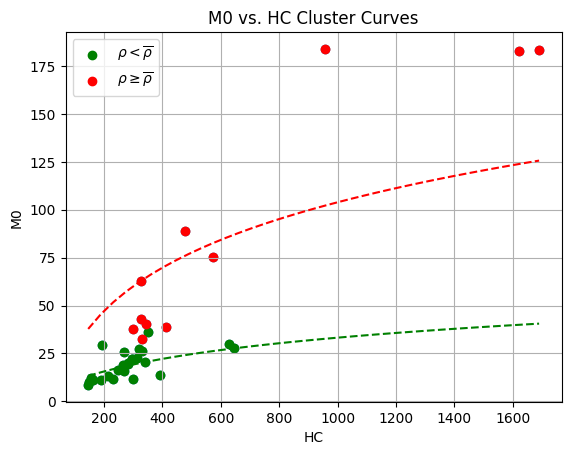

In [36]:
# Try criteria
c = data['deltaHC / beta'] < data['deltaHC / beta'].mean()

# Plot points with approximation curves
plt.scatter(X, Y)
plt.scatter(X[c], Y[c], color = 'green', label = r'$\rho < \overline{\rho}$')
plt.scatter(X[np.logical_not(c)], Y[np.logical_not(c)], color = 'red', label = r'$\rho \geq \overline{\rho}$')
plt.plot(line, (np.log(1 / (line)) ** 2 - 15) + (500 / line), color = 'green', linestyle = '--')
plt.plot(line, (np.log(1 / (line ** 1.7)) ** 2 - 35 + (2 ** (1 / line))), color = 'red', linestyle = '--')
plt.grid()
plt.xlabel('HC')
plt.ylabel('M0')
plt.title('M0 vs. HC Cluster Curves')
plt.legend()

''' TODO
backward selection of features to produce gradient coloring
partition curves of expectation (3-4 categories)
heatmap
'''

### TODO: Experiment with separating data using third dimension

' TODO\ngradient coloring via beta - 2D\n'

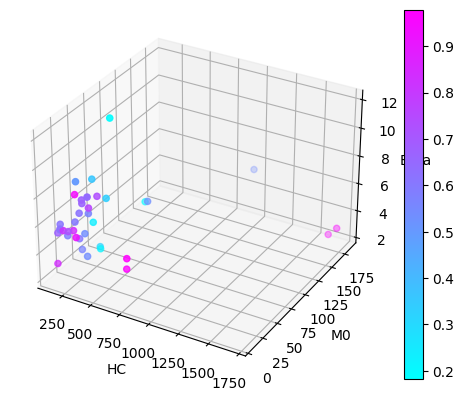

In [49]:
param = 'Wall loss factor'
c = data[param] < data[param].mean()
Z = data[param]

ax = plt.axes(projection = '3d')

''' First Attempt
ax.scatter(X[c], Y[c], Z[c], c='blue', cmap = 'viridis')
ax.scatter(X[np.logical_not(c)], Y[np.logical_not(c)], Z[np.logical_not(c)], c='red', cmap = 'viridis')
ax.set_xlabel('HC')
ax.set_ylabel('M0')
ax.set_zlabel('Crossing Time')
'''

# Heatmap test
scatter = ax.scatter(X, Y, Z, c = data['beta'], cmap = 'cool')
plt.colorbar(scatter)
ax.set_xlabel('HC')
ax.set_ylabel('M0')
ax.set_zlabel('Beta')

''' TODO
gradient coloring via beta - 2D
'''

# One-Sample Hypothesis Test for Mean used as criteria in M0 vs HC curves

In [38]:
sample = data['deltaHC / beta']
data['deltaHC / beta'].mean()

745.7566868064129

In [39]:
# if p-value higher than significance level, don't reject null hypothesis
# if lower, reject null hypothesis
ttest_1samp(sample, 745)

TtestResult(statistic=0.00778521617136566, pvalue=0.9938313421519555, df=36)